In [ ]:
! pip install huggingface_hub
! pip install -U sentence-transformers
! pip install nltk
! pip install datasets

In [ ]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
import re
from nltk import sent_tokenize, word_tokenize
import nltk

nltk.download("punkt")
import math

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Define the path to the JSON file
json_file_path = "/content/COVID-QA.json"

# Load the JSON file into a Pandas DataFrame
data = pd.read_json(json_file_path)
format_data = data["data"]

In [ ]:
# remove the dictionary form
data_df = pd.json_normalize(format_data, "paragraphs")

In [ ]:
# Transform and restructure data

schema = {
    "question": str,
    "answer_text": str,
    "answer_start": int,
    "is_impossible": bool,
    "document_id": int,
    "id": int,
    "context": str,
}
current_df = pd.DataFrame(columns=schema.keys())
for index, row in data_df.iterrows():
    for qas in row["qas"]:
        data = {
            "question": qas["question"],
            "answer_text": qas["answers"][0]["text"],
            "answer_start": qas["answers"][0]["answer_start"],
            "is_impossible": qas["is_impossible"],
            "document_id": row["document_id"],
            "id": qas["id"],
            "context": "",
        }
        current_df = current_df._append(data, ignore_index=True)

In [ ]:
data_context = data_df["context"]
data_document_id = data_df["document_id"]

In [ ]:
def clean_data(text):
    # Extract abstract content
    index = text.find("\nAbstract: ")
    if index != -1:
        cleaned_text = text[index + len("\nAbstract: ") :]
    else:
        cleaned_text = text  # If "\nAbstract: " is not found, keep the original text

    # Remove both http and https links using a regular expression
    cleaned_text = re.sub(
        r"(http(s|)\/\/:( |)\S+)|(http(s|):\/\/( |)\S+)", "", cleaned_text
    )

    # Remove DOI patterns like "doi:10.1371/journal.pone.0007211.s003"
    cleaned_text = re.sub(r"doi:( |)\w+", "", cleaned_text)

    # Remove the "(0.11 MB DOC)" pattern
    cleaned_text = re.sub(r"\(0\.\d+ MB DOC\)", "", cleaned_text)

    cleaned_text = re.sub(r"www\.\w+(.org|)", "", cleaned_text)

    # Remove text within square brackets, e.g., [Example]
    cleaned_text = re.sub(r"\[((\d+)|(\d+, ))*?\]", "", cleaned_text)
    cleaned_text = re.sub(r"\[", " ", cleaned_text)
    cleaned_text = re.sub(r"\]", " ", cleaned_text)

    # Remove patterns like (Author et al., Year)
    cleaned_text = re.sub(r"\(\w+(?: \w+)* et al\., \d{4}\)", ".", cleaned_text)

    # Remove patterns like (1), (1, 2), etc.
    cleaned_text = re.sub(r"\(((\d+)|(\d+, ))*\)", ".", cleaned_text)
    cleaned_text = re.sub(r"\(", " ", cleaned_text)
    cleaned_text = re.sub(r"\)", " ", cleaned_text)

    cleaned_text = re.sub(r"\n\n", " ", cleaned_text)
    cleaned_text = re.sub(r"\n", " ", cleaned_text)
    cleaned_text = re.sub(r"  ", " ", cleaned_text)
    cleaned_text = re.sub(r"(  )+", " ", cleaned_text)

    return cleaned_text.strip()


# Apply the combined function to each element of the Series

In [ ]:
data_cleaned = data_context.apply(clean_data)

In [ ]:
# Create a map for context and document_id for future map
data_context = pd.concat([data_cleaned, data_document_id], axis=1)

In [ ]:
for doc_id in current_df["document_id"].unique():
    data_context.loc[data_context["document_id"] == doc_id, "document_id_count"] = (
        current_df["document_id"] == doc_id
    ).sum()

In [ ]:
data_context["context"].apply(lambda k: len(sent_tokenize(k))).describe()

count    147.000000
mean     173.802721
std      100.235862
min       13.000000
25%      109.000000
50%      153.000000
75%      219.500000
max      497.000000
Name: context, dtype: float64

In [ ]:
data_context["context"].apply(lambda k: len(word_tokenize(k))).describe()

count      147.000000
mean      4304.428571
std       2312.614585
min        417.000000
25%       2740.000000
50%       3835.000000
75%       5541.500000
max      11691.000000
Name: context, dtype: float64

In [ ]:
data_context["sentences"] = data_context["context"].apply(lambda k: sent_tokenize(k))

In [ ]:
def count_words(sentence):
    return len(word_tokenize(sentence))

In [ ]:
data_context["sentence_length"] = data_context["sentences"].apply(
    lambda sentences: [count_words(sentence) for sentence in sentences]
)

In [ ]:
statistics = data_context["sentence_length"].apply(
    lambda lengths: pd.Series(lengths).describe()
)

<Axes: >

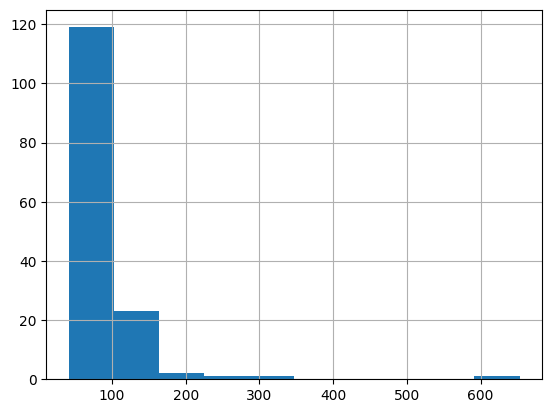

In [ ]:
statistics["max"].hist()

## Check answer in context

In [ ]:
ind = 0
for index, row in current_df.iterrows():
    document_id = row["document_id"]
    context_value = data_context[data_context["document_id"] == document_id][
        "context"
    ].values[0]

    if clean_data(row["answer_text"]) not in context_value:
        ind += 1
        # print(row)
print("Number of invalid: ", ind)

In [ ]:
sentence_transformer_data = current_df

In [ ]:
print(len(sentence_transformer_data))

In [ ]:
print(len(sentence_transformer_data["document_id"].unique()))

# Sentence Transformer Data Preparation

In [ ]:
embedder = SentenceTransformer("multi-qa-mpnet-base-dot-v1")


def encoding(value):
    return embedder.encode(value, convert_to_tensor=True, show_progress_bar=False).to(
        "cuda"
    )

In [ ]:
def count_valid_cases(answer_text, context):
    answer_text = clean_data(answer_text)
    percent = 0.8
    sentence_answers = sent_tokenize(answer_text)
    count = 0
    if not sentence_answers:
        return False

    for answer in sentence_answers:
        if answer in context:
            count += 1

    if count / len(sentence_answers) >= percent:
        return True
    return False


schema = {
    "question": str,
    "answer": str,
    "retrieved_context": list,
    "document_id": int,
    "id": int,
}

In [ ]:
results = []

# Other parameters
for top_k in range(2, 12, 1):
    for chunk_size in [32, 64, 128, 256, 512]:
        for min_sentences_per_chunk in range(2, 12, 1):
            count_match = 0
            window_size = math.ceil(min_sentences_per_chunk * 0.25)
            overlap_chunk_size = chunk_size * 0.25

            def chunk_splitter(context):
                sentences = sent_tokenize(context)
                chunks = []
                current_chunk = []

                for sentence in sentences:
                    if len(current_chunk) < min_sentences_per_chunk:
                        current_chunk.append(sentence)
                        continue
                    elif (
                        len(
                            nltk.word_tokenize(" ".join(current_chunk) + " " + sentence)
                        )
                        < chunk_size
                    ):
                        current_chunk.append(sentence)
                        continue

                    chunks.append(" ".join(current_chunk))
                    new_chunk = current_chunk[-window_size:]
                    new_window = window_size
                    buffer_new_chunk = new_chunk

                    while len(word_tokenize(" ".join(new_chunk))) <= overlap_chunk_size:
                        buffer_new_chunk = new_chunk
                        new_window += 1
                        new_chunk = current_chunk[-new_window:]

                        if new_window >= len(current_chunk):
                            break

                    current_chunk = buffer_new_chunk
                    current_chunk.append(sentence)

                if current_chunk:
                    chunks.append(" ".join(current_chunk))

                return chunks

            texts = {}

            # Assuming you have a DataFrame called data_context
            for ind, data in data_context.iterrows():
                chunks = chunk_splitter(data["context"])
                doc_id = data["document_id"]
                texts[doc_id] = chunks

            texts_embedding = {}
            for key, value in texts.items():
                embedded_corpus = encoding(value)
                texts_embedding[key] = embedded_corpus

            sentence_transformer_data_results = pd.DataFrame(columns=schema.keys())
            for ind, data in sentence_transformer_data.iterrows():
                query_embedding = encoding(data["question"])
                corpus_embeddings = texts_embedding[int(data["document_id"])]
                answer = data["answer_text"]

                hits = util.semantic_search(
                    query_embedding, corpus_embeddings, top_k=top_k
                )[0]
                merged_context = " ".join(
                    [texts[int(data["document_id"])][hit["corpus_id"]] for hit in hits]
                )
                sentence_transformer_data_results = (
                    sentence_transformer_data_results._append(
                        {
                            "answer": answer,
                            "retrieved_context": merged_context,
                            "document_id": data["document_id"],
                            "id": data["id"],
                        },
                        ignore_index=True,
                    )
                )

                count_match_local = count_valid_cases(answer, merged_context)
                count_match += 1 if count_match_local else 0

            word_tokenized_contexts = sentence_transformer_data_results[
                "retrieved_context"
            ].apply(nltk.word_tokenize)
            word_tokenize_lengths = word_tokenized_contexts.apply(len)

            min_word_tokenize_length = word_tokenize_lengths.min()
            max_word_tokenize_length = word_tokenize_lengths.max()
            median_word_tokenize_length = word_tokenize_lengths.median()
            mean_word_tokenize_length = word_tokenize_lengths.mean()

            percentage_match = (
                count_match / len(sentence_transformer_data_results)
            ) * 100

            result = {
                "min_sentences_per_chunk": min_sentences_per_chunk,
                "chunk_size": chunk_size,
                "top_k": top_k,
                "window_size": window_size,
                "overlap_chunk_size": overlap_chunk_size,
                "count_match": count_match,
                "percentage_match": percentage_match,
                "min_word_tokenize_length": min_word_tokenize_length,
                "max_word_tokenize_length": max_word_tokenize_length,
                "median_word_tokenize_length": median_word_tokenize_length,
                "mean_word_tokenize_length": mean_word_tokenize_length,
            }
            results.append(result)
            print(result)

results_df = pd.DataFrame(results)

In [ ]:
results = []

# Other parameters
for top_k in range(2, 12, 1):
    for chunk_size in [32, 64, 128, 256, 512]:
        min_sentences_per_chunk = max(math.ceil(chunk_size / 25), 2)
        count_match = 0
        window_size = math.ceil(min_sentences_per_chunk * 0.25)
        overlap_chunk_size = chunk_size * 0.25

        def chunk_splitter(context):
            sentences = sent_tokenize(context)
            chunks = []
            current_chunk = []

            for sentence in sentences:
                if len(current_chunk) < min_sentences_per_chunk:
                    current_chunk.append(sentence)
                    continue
                elif (
                    len(nltk.word_tokenize(" ".join(current_chunk) + " " + sentence))
                    < chunk_size
                ):
                    current_chunk.append(sentence)
                    continue

                chunks.append(" ".join(current_chunk))
                new_chunk = current_chunk[-window_size:]
                new_window = window_size
                buffer_new_chunk = new_chunk

                while len(word_tokenize(" ".join(new_chunk))) <= overlap_chunk_size:
                    buffer_new_chunk = new_chunk
                    new_window += 1
                    new_chunk = current_chunk[-new_window:]

                    if new_window >= len(current_chunk):
                        break

                current_chunk = buffer_new_chunk
                current_chunk.append(sentence)

            if current_chunk:
                chunks.append(" ".join(current_chunk))

            return chunks

        texts = {}

        # Assuming you have a DataFrame called data_context
        for ind, data in data_context.iterrows():
            chunks = chunk_splitter(data["context"])
            doc_id = data["document_id"]
            texts[doc_id] = chunks

        texts_embedding = {}
        for key, value in texts.items():
            embedded_corpus = encoding(value)
            texts_embedding[key] = embedded_corpus

        sentence_transformer_data_results = pd.DataFrame(columns=schema.keys())
        for ind, data in sentence_transformer_data.iterrows():
            query_embedding = encoding(data["question"])
            corpus_embeddings = texts_embedding[int(data["document_id"])]
            answer = data["answer_text"]

            hits = util.semantic_search(
                query_embedding, corpus_embeddings, top_k=top_k
            )[0]
            merged_context = " ".join(
                [texts[int(data["document_id"])][hit["corpus_id"]] for hit in hits]
            )
            sentence_transformer_data_results = (
                sentence_transformer_data_results._append(
                    {
                        "answer": answer,
                        "retrieved_context": merged_context,
                        "document_id": data["document_id"],
                        "id": data["id"],
                    },
                    ignore_index=True,
                )
            )

            count_match_local = count_valid_cases(answer, merged_context)
            count_match += 1 if count_match_local else 0

        word_tokenized_contexts = sentence_transformer_data_results[
            "retrieved_context"
        ].apply(nltk.word_tokenize)
        word_tokenize_lengths = word_tokenized_contexts.apply(len)

        min_word_tokenize_length = word_tokenize_lengths.min()
        max_word_tokenize_length = word_tokenize_lengths.max()
        median_word_tokenize_length = word_tokenize_lengths.median()
        mean_word_tokenize_length = word_tokenize_lengths.mean()

        percentage_match = (count_match / len(sentence_transformer_data_results)) * 100

        result = {
            "min_sentences_per_chunk": min_sentences_per_chunk,
            "chunk_size": chunk_size,
            "top_k": top_k,
            "window_size": window_size,
            "overlap_chunk_size": overlap_chunk_size,
            "count_match": count_match,
            "percentage_match": percentage_match,
            "min_word_tokenize_length": min_word_tokenize_length,
            "max_word_tokenize_length": max_word_tokenize_length,
            "median_word_tokenize_length": median_word_tokenize_length,
            "mean_word_tokenize_length": mean_word_tokenize_length,
        }
        results.append(result)
        print(result)

results_df = pd.DataFrame(results)

# Push to hub

In [ ]:
from huggingface_hub import notebook_login
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# sentence_transformer_data_results

In [ ]:
def split(param_df):
    trainset_percent = 0.9
    testset_percent = 0.1

    # Create a DataFrame to store unique 'document_id' values and their counts
    context_pd = pd.DataFrame(columns=["document_id", "document_id_count"])

    unique_doc_ids = param_df["document_id"].unique()

    for doc_id in unique_doc_ids:
        doc_id_count = int((param_df["document_id"] == doc_id).sum())
        context_pd = context_pd._append(
            {"document_id": doc_id, "document_id_count": doc_id_count},
            ignore_index=True,
        )
    x = 1

    # Set up the loop to adjust x and y
    while True:
        # Split the data with the current values of x and y
        trainset_context, testset_context = train_test_split(
            context_pd, test_size=1 - trainset_percent, random_state=x
        )

        # Calculate the sums for trainsetr_context and sentence_transformer_context
        train_sum = int(trainset_context["document_id_count"].sum())
        test_sum = int(testset_context["document_id_count"].sum())

        # Check if the sums meet the desired conditions
        if (
            test_sum >= testset_percent * len(param_df) - 10
            and test_sum <= testset_percent * len(param_df) + 10
        ):
            break
        else:
            x += 1
    train_data = param_df[param_df["document_id"].isin(trainset_context["document_id"])]
    test_data = param_df[param_df["document_id"].isin(testset_context["document_id"])]

    print("Train_data context: ", len(train_data["document_id"].unique()))
    print("Test_data context: ", len(test_data["document_id"].unique()))
    print("Train_data: ", len(train_data))
    print("Test_data: ", len(test_data))
    return (train_data, test_data)

In [ ]:
(train_df, test_df) = split(sentence_transformer_data_results)

In [ ]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [ ]:
hf_dataset = DatasetDict(
    {
        "train": train_ds,
        "test": test_ds,
    }
)

In [ ]:
hf_dataset

In [ ]:
hf_dataset.push_to_hub("minh21/COVID-QA-sentence-transformer-data")

# testset_data_results

In [ ]:
testset_data_results = testset_data_results.reset_index(drop=True)
testset_data_results_dataset = Dataset.from_pandas(testset_data_results)

In [ ]:
testset_data_results_dataset.push_to_hub("minh21/COVID-QA-testset-data")

# qa_transformer_data_results

In [ ]:
qa_transformer_data_results = qa_transformer_data_results.reset_index(drop=True)

In [ ]:
(train_df, val_df) = split(qa_transformer_data_results)

In [ ]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

In [ ]:
hf_dataset = DatasetDict(
    {
        "train": train_ds,
        "validation": val_ds,
    }
)

In [ ]:
hf_dataset

In [ ]:
hf_dataset.push_to_hub("minh21/COVID-QA-sentence-Question-Answering-Transformer-data")